Policy Function Matrix P_k:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


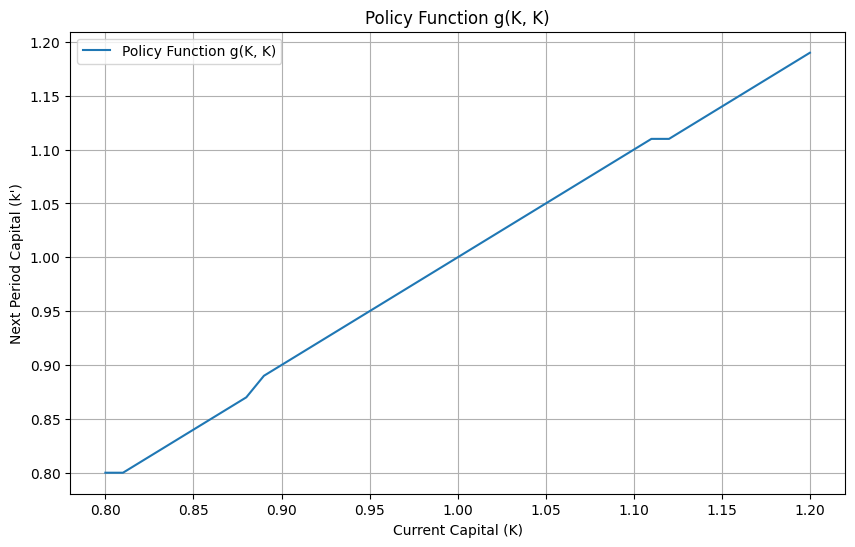

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 0.25
beta = 0.96
A = (alpha * beta) ** (-1)
delta = 1
n = 41  #
kappa = 0.01
k_min = 0.8
k_max = 1.2
k_grid = np.linspace(k_min, k_max, n)  # Grid for k and K
eps0 = 0.00001  

# Funcs for later
def rental_rate(K):
    return alpha * A * K ** (alpha - 1)

def wage_rate(K):
    return A * K ** alpha - rental_rate(K) * K


def utility(k, K, k_prime):
    return np.log(max((1 + rental_rate(K) - delta) * k + wage_rate(K) - k_prime, 1e-10))


V = np.zeros((n, n))  # init value
G = np.ones(n)  # init

# Value function iteration
def value_function_iteration(V, G, k_grid, eps0):
    n = len(k_grid)
    U = np.zeros((n * n, n))  
    
    
    for i in range(n):
        for j in range(n):
            for iprime in range(n):
                U[i * n + j, iprime] = utility(k_grid[i], k_grid[j], k_grid[iprime])
    
    # Iter it till converge
    iteration = 0
    while True:
        iteration += 1
        
        # Markov for the prod process discrete approx
        QK = np.zeros((n, n))
        for j in range(n):
            Kj = k_grid[j]
            Kj_prime = G[j]  
            j_prime = np.argmin(np.abs(k_grid - Kj_prime))
            QK[j, j_prime] = 1
        EV = np.dot(V, QK.T)
        W = U + beta * np.kron(np.ones((n, 1)), EV.T)
        
        V_new = np.max(W, axis=1)
        V_new = V_new.reshape((n, n))
        g = np.argmax(W, axis=1)  
        g = g.reshape((n, n))  
        
        if np.max(np.abs(V_new - V)) < eps0:

            break
        V = V_new
    
    # get the pol func
    P_k = np.zeros((n, n))  
    for i in range(n):
        optimal_index = g[i, i]  
        P_k[i, optimal_index] = 1
    
    return V, P_k,g

# Run it
V, P_k,g = value_function_iteration(V, G, k_grid, eps0)


print("Policy Function Matrix P_k:")
print(P_k)


optimal_k_prime_indices = np.argmax(P_k, axis=1)
optimal_k_prime = k_grid[optimal_k_prime_indices]

plt.figure(figsize=(10, 6))
plt.plot(k_grid, optimal_k_prime, label="Policy Function g(K, K)")
plt.xlabel("Current Capital (K)")
plt.ylabel("Next Period Capital (k')")
plt.title("Policy Function g(K, K)")
plt.legend()
plt.grid()
plt.show()

Typical look for the Value function, being increasing and concave

Aggregate transition function G(K) converged.


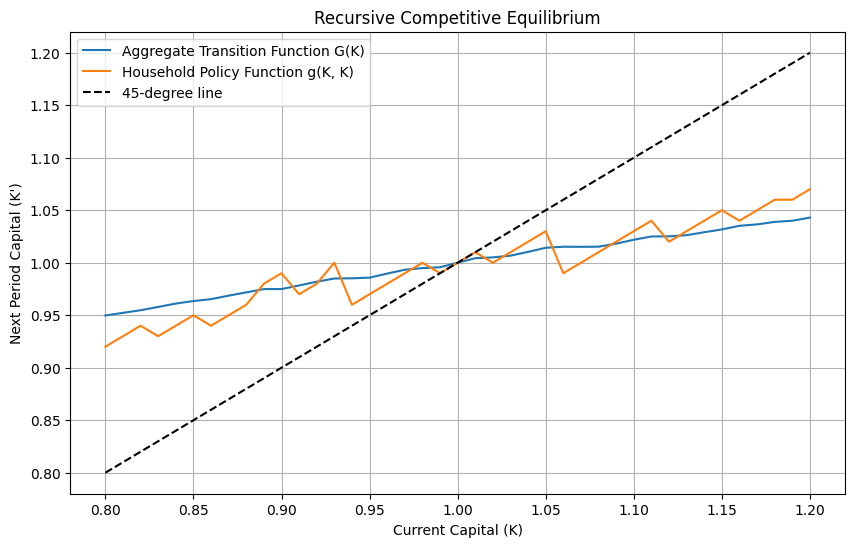

In [11]:
eps1 = 0.03
xi = 0.99
def relaxation_iteration(V, G, k_grid, xi, eps0, eps1):
    n = len(k_grid)
    iteration = 0
    while True:
        iteration += 1
    
        
        # Solve household problem to get policy function
        V, P_k, g = value_function_iteration(V, G, k_grid, eps0)
        
        # Compute new G(K) using relaxation
        G_new = np.zeros(n)
        for i in range(n):
            G_new[i] = k_grid[g[i, i]]  # g(K_i, K_i)
        
        # Check convergence of G(K)
        if np.max(np.abs(G_new - G)) < eps1:
            print("Aggregate transition function G(K) converged.")
            break
        
        # Update G(K) using relaxation
        G = xi * G + (1 - xi) * G_new
    
    return V, P_k, G

solV, solP_k, solG = relaxation_iteration(V, G, k_grid, xi, eps0, eps1)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(k_grid, solG, label="Aggregate Transition Function G(K)")
plt.plot(k_grid, k_grid[np.argmax(solP_k, axis=1)], label="Household Policy Function g(K, K)")
plt.plot(k_grid, k_grid, 'k--', label="45-degree line")
plt.xlabel("Current Capital (K)")
plt.ylabel("Next Period Capital (K')")
plt.title("Recursive Competitive Equilibrium")
plt.legend()
plt.grid()
plt.show()

It takes very long to converge, so I have to use a higher error tolerance and that is seen in how bumpy the orange line is. But, they do converge toward one another which is a positive and the goal of the model computation.